In [1]:
%%capture
%reload_ext autoreload
%autoreload 2
%cd ..
%cd src

In [97]:
from taa.tools.data import get_strategy_price_data
from taa.strategy.static import STRATEGIES
from taa.strategy.strategies import StrategyPipeline
from taa.strategy.signals import Signal
from taa.backtest.positions import EqualWeights, RiskParity, vigilant_allocation
from taa.backtest.performance import Tearsheet
from taa.backtest.returns import Backtester
from taa.backtest.returns import get_historical_total_return

import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

In [33]:
start, end = "2011-01-01", "2023-05-01"
rebalance_dates = pd.bdate_range(start, end, freq="BM")

pipeline = StrategyPipeline(STRATEGIES)
data = get_strategy_price_data(pipeline, start, end).dropna()

In [122]:
all_strategies = []

# ivy
strategy = pipeline.ivy
strategy_data = data[strategy.risk_assets]
signals = Signal(strategy_data).sma_crossover(10).dropna()

weights = signals.apply(lambda x: np.where(x > 0, strategy.weights[0], 0))
weights.loc[:, strategy.safe_assets] = 1 - weights.sum(axis=1)
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# benchmark strategies
assets = strategy.get_tickers()
returns = data.pct_change().dropna().loc[:, assets]

ew = EqualWeights(assets, rebalance_dates).weights
rp = RiskParity(assets, rebalance_dates, returns).weights

# robust asset allocation
strategy = pipeline.raab
strategy_data = data[strategy.get_tickers()]
signal_1 = Signal(strategy_data).classic_momentum(end=0).dropna()
signal_2 = Signal(strategy_data).sma_crossover(12, False).dropna()
cond_1 = np.where(signal_1[strategy.risk_assets].gt(signal_1[strategy.safe_assets].values), 1, 0)
cond_2 = np.where(strategy_data.reindex(signal_2.index) > signal_2, 1, 0)[:,:-1]
final_signal = cond_1 + cond_2
cash = np.atleast_2d(len(strategy.risk_assets) - np.sum(final_signal / 2, 1)).T
weights = pd.DataFrame(np.hstack([final_signal, cash]), index=signal_1.index, columns=signal_1.columns)
weights = weights.div(weights.sum(axis=1).values.reshape(-1, 1))
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# vigilant asset allocation g12
strategy = pipeline.vaag12
strategy_data = data[strategy.get_tickers()]
signal = Signal(strategy_data).momentum_score()
weights = pd.concat([x for x in signal.apply(lambda x: vigilant_allocation(x, strategy.risk_assets, strategy.safe_assets), axis=1)])
weights.index = signal.index
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# concat all strats
all_strategies = reduce(lambda x, y: x.join(y, how="outer"), all_strategies).fillna(0)

In [94]:
bt = Backtester(all_strategies, "USD")
port_total_returns = bt.run(return_type="total")
port_total_returns.add(1).cumprod().tail()

,IVY,RAAB,VAAG12,RP,EW
Date,,,,,
2022-12-30,1.616011,1.536700,1.383124,1.097615,1.515098
2023-01-31,1.620604,1.623727,1.490593,1.119874,1.592192
2023-02-28,1.592201,1.572305,1.442638,1.118646,1.540615
2023-03-31,1.613677,1.585886,1.556839,1.127960,1.556855
2023-04-28,1.627449,1.612573,1.560581,1.132288,1.565830


In [95]:
port_price_returns = bt.run(return_type="price")
port_price_returns.add(1).cumprod().tail()

,IVY,RAAB,VAAG12,RP,EW
Date,,,,,
2022-12-30,1.375769,1.219068,1.114799,1.006054,1.222701
2023-01-31,1.379679,1.288106,1.201419,1.026457,1.284917
2023-02-28,1.352819,1.246671,1.162063,1.021892,1.242001
2023-03-31,1.367064,1.254360,1.254054,1.027373,1.250713
2023-04-28,1.375816,1.274365,1.256783,1.027401,1.256549


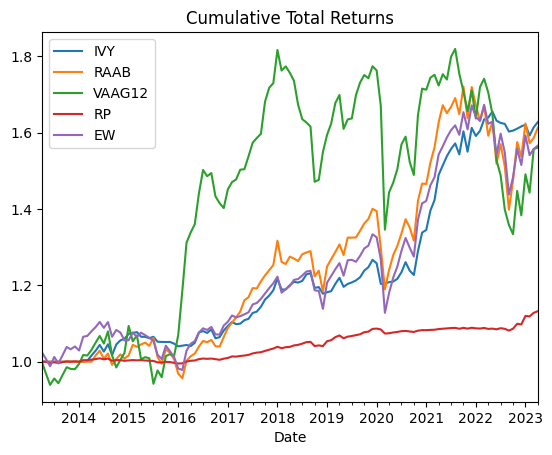

In [104]:
port_total_returns.add(1).cumprod().plot(title="Cumulative Total Returns");

In [24]:
Tearsheet(port_total_returns).summary()

,IVY,EW
#obs,108.000000,108.000000
#years,271.333333,271.333333
Total Return,0.567386,0.421313
Annual. Return,0.001658,0.001297
Volatility,0.054186,0.093702
MaxDD,-0.056752,-0.161843
Skewness,0.105130,-0.732508
Kurtosis,4.289839,5.583809
Sharpe Ratio,0.950165,0.464514
StdErr,0.061703,0.064214
